<a href="https://colab.research.google.com/github/Verifieddanny/-sui-student-management-system-vector/blob/main/DDos_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HTTP DoS Detection - Random forest Classifer

1. Load Libraries

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2. Load Datasets

In [2]:
http_dos_df = pd.read_csv("http dos dataset.csv")
grasec_get_df = pd.read_csv("capture_http_get.pcap_Flow.csv")
grasec_post_df = pd.read_csv("capture_http_post.pcap_Flow.csv")
csic_df = pd.read_csv("csic_database.csv")
http_full_df = pd.read_csv("http full dataset.csv")

3. Label Data

In [17]:
grasec_get_df['Label'] = 1
grasec_post_df['Label'] = 1
csic_df['Label'] = 0

attacker_ips = ['192.168.1.64', '192.168.1.65', '192.168.1.66', '192.168.1.67', '192.168.1.68']
http_dos_df['Label'] = http_dos_df['Source'].apply(lambda ip: 1 if ip in attacker_ips else 0)
http_full_df['Label'] = http_full_df['Source'].apply(lambda ip: 1 if ip in attacker_ips else 0)

In [24]:
print(csic_df.columns.tolist())

['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght', 'content', 'classification', 'URL', 'Label']


4. Feature Engineering

In [29]:
# Create consistent features across datasets
http_dos_df['method'] = http_dos_df['Info'].str.extract(r'^(GET|POST)').fillna('RESPONSE')
http_dos_df['length'] = http_dos_df['Length']


# --- GRASEC GET/POST (flow-based, no HTTP Info) ---
# Treat all as POST or GET respectively, or just label as GENERIC_POST / GENERIC_GET
grasec_get_df['method'] = 'GET'
grasec_get_df['length'] = grasec_get_df['Pkt Len Mean']

grasec_post_df['method'] = 'POST'
grasec_post_df['length'] = grasec_post_df['Pkt Len Mean']


# --- CSIC (pre-parsed) ---
csic_df['method'] = csic_df['Method'].fillna('RESPONSE')
csic_df['length'] = csic_df['lenght'].str.extract('(\d+)').fillna(0)


# --- Combine and encode ---
combined_df = pd.concat([
    http_dos_df[['method', 'length', 'Label']],
    grasec_get_df[['method', 'length', 'Label']],
    grasec_post_df[['method', 'length', 'Label']],
    csic_df[['method', 'length', 'Label']]
], ignore_index=True).dropna()

# Coerce to numeric, errors will be set to NaN, then fill with 0
combined_df['length'] = pd.to_numeric(combined_df['length'], errors='coerce').fillna(0)

le = LabelEncoder()
combined_df['method'] = le.fit_transform(combined_df['method'])

5. Train/Test split

In [30]:
X = combined_df[['method', 'length']]
y = combined_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

6. Model

In [31]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=5, bootstrap=True, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

7. Evaluation

In [32]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.66      0.79     41204
           1       0.93      1.00      0.96    197008

    accuracy                           0.94    238212
   macro avg       0.96      0.83      0.88    238212
weighted avg       0.94      0.94      0.93    238212



8. Confusion Matrix

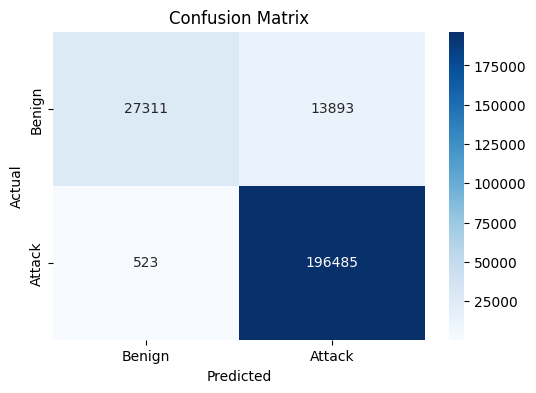

In [33]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','Attack'], yticklabels=['Benign','Attack'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
